In [219]:
import pandas as pd;
import numpy as np;
import os
from skimage.transform import resize
from imageio import imread
import datetime
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, GRU, Layer
from tensorflow.keras.models import Sequential, load_model

from tensorflow.keras.layers import Dense, Flatten, TimeDistributed, BatchNormalization, Activation, Dropout, LSTM
from tensorflow.keras.layers import GlobalAveragePooling3D
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D, ReLU, ZeroPadding2D, ZeroPadding3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications import mobilenet

from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics  

warnings.filterwarnings('ignore')

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [3]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
else:
    print('Found GPU at: {}'.format(device_name))

GPU device not found


In [4]:
# read the train and the validation file and initialize the batch size
train_doc = np.random.permutation(open('input/train.csv').readlines())
val_doc = np.random.permutation(open('input/val.csv').readlines())

### Generator utility functions

In [220]:
def preprocessImage(image, y, z):
    """
    Helper fucntion to resize & normalize image
    y: height
    z: width
    """
    # resize size image
    image_new = tf.image.resize(image, [y, z], method='nearest')

    
    return image_new/255

In [221]:
def augment_image(image):
    """
    Helper function to perform data augmentation
    """
    # Randomly flip the image horizontally
    image = tf.image.random_flip_left_right(image)
    
    # Randomly adjust the brightness of the image
    image = tf.image.random_brightness(image, max_delta=0.2)
    
    # Randomly adjust the contrast of the image
    image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
    
    # Randomly rotate the image
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    
    return image

In [233]:
def getBatchData(source_path, t, batch, batch_size, img_tensor, augmentation):
    '''Function to get Batch Data in generator form'''
    
    # read the tensor image and get the x,y,z info
    [x,y,z] = [len(img_tensor[0]),img_tensor[1], img_tensor[2]]
    
    # list of folder indices
    img_idx = img_tensor[0]
    
    # create a batch_data and batch_labels
    # x is the number of images you use for each video, 
    #(y,z) is the final size of the input images and 3 is the number of channels RGB
    batch_data = np.zeros((batch_size,x,y,z,3)) 
    # batch_labels is the one hot representation of the output
    batch_labels = np.zeros((batch_size,5)) 
    
    # if augmentation is set to true
    # create the augmented data
    if (augmentation): 
        batch_data_aug = np.zeros((batch_size,x,y,z,3))
        batch_labels_aug = np.zeros((batch_size,5))
    
    # iterate over the batch_size
    for folder in range(batch_size):
        # read all the images in the folder
        imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
        
        #  Iterate iver the frames/images of a folder to read them in
        for idx,item in enumerate(img_idx):
            imgPath = source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]
            image = tf.io.read_file(imgPath)
            #print(imgPath)
            image = tf.image.decode_jpeg(image, channels=3)  # Decode JPEG image with 3 channels (RGB)    

            #crop the images and resize them. Note that the images are of 2 different shape 
            #and the conv3D will throw error if the inputs in a batch have different shapes
            # populate the batch data
            preProcessImage = preprocessImage(image, y, z)
            batch_data[folder,idx,:,:,:] = preProcessImage
            
            if(augmentation):
                batch_data_aug[folder, idx,:,:,:] = augment_image(preProcessImage)
        
        # populate the label data one-hot encoding
        batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
        
    # condition checks whether data augmentation is enabled
    if (augmentation):
        batch_data=tf.concat([batch_data,batch_data_aug], axis=0)
        batch_labels=tf.concat([batch_labels,batch_labels], axis=0)
    
    return batch_data, batch_labels

In [223]:
def generator(source_path, folder_list, batch_size, img_tensor, augmentation):
    '''Function to generate the batch data'''
    
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    while True:
        # get the random folder list
        t = np.random.permutation(folder_list)
        
        # number of batches 
        num_batches = int(len(folder_list)/batch_size)
        #print("no of batches::",num_batches)
        
        for batch in range(num_batches): # we iterate over the number of batches
            yield getBatchData(source_path, t, batch, batch_size, img_tensor, augmentation)
        
        # write the code for the remaining data points which are left after full batches
        # checking if any remaining batches are there or not
        if len(folder_list)%batch_size != 0:
            # updated the batch size and yield
            batch_size = len(folder_list)%batch_size
            yield getBatchData(source_path, t, batch, batch_size, img_tensor, augmentation)

### Set the parameters

In [201]:
curr_dt_time = datetime.datetime.now()
train_path = 'input/train'
val_path = 'input/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)

num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

num_epochs = 30
print ('# epochs =', num_epochs)

batch_size = 30
print ('# batchSize =', batch_size)

# training sequences = 663
# validation sequences = 100
# epochs = 30
# batchSize = 30


### Function to set image tensors

In [202]:
def getImgTensor(n_frames, size):
    """
    size: image size
    """
    img_idx = np.round(np.linspace(0, n_frames-1, n_frames)).astype(int)
    return [img_idx, size, size, 3]

# define image tensor size
n_frames = 30
img_tensor = getImgTensor(n_frames, 100)
print ('# img_tensor =', img_tensor)

# img_tensor = [array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]), 100, 100, 3]


In [203]:
# check complete batch shape
sample_generator = generator(train_path, train_doc, batch_size, img_tensor, False)
sample_batch_data, sample_batch_labels = next(sample_generator)
print(sample_batch_data.shape)

# validation batch sample
sample_val_generator = generator(val_path, val_doc, batch_size, img_tensor, False)
sample_val_batch_data, sample_val_batch_labels = next(sample_val_generator)
print(sample_val_batch_data.shape)

Source path =  input/train ; batch size = 30
(30, 30, 100, 100, 3)
Source path =  input/val ; batch size = 30
(30, 30, 100, 100, 3)


In [204]:
 y = ['LeftSwipe', 'RightSwipe', 'Stop', 'ThumbsDown', 'ThumbsUp']

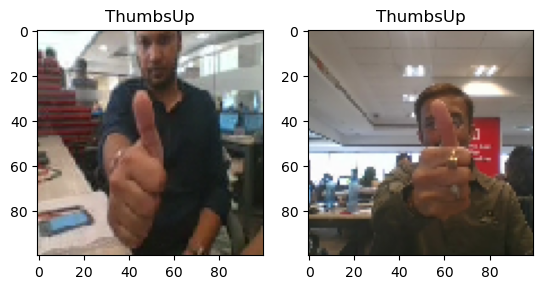

In [205]:
# lets plot some sample images
# plot generated sample images
fig, ax = plt.subplots(1,2)
ax[0].imshow(sample_val_batch_data[16,10,:,:,:]) 
ax[0].title.set_text(f"{y[np.argmax(sample_val_batch_labels[16])]}")
ax[1].imshow(sample_val_batch_data[25,10,:,:,:])
ax[1].title.set_text(f"{y[np.argmax(sample_val_batch_labels[25])]}")
plt.show()

In [14]:
# lets test with augmentation
# check complete batch shape
sample_generator = generator(train_path, train_doc, batch_size, img_tensor, True)
sample_batch_data, sample_batch_labels = next(sample_generator)
print(sample_batch_data.shape)

# validation batch sample
sample_val_generator = generator(val_path, val_doc, batch_size, img_tensor, True)
sample_val_batch_data, sample_val_batch_labels = next(sample_val_generator)
print(sample_val_batch_data.shape)

Source path =  input/train ; batch size = 30
(60, 30, 100, 100, 3)
Source path =  input/val ; batch size = 30
(60, 30, 100, 100, 3)


### Model Utility Functions

In [15]:
def plotModelHistory(h):
    '''Function to plot the model history'''
    
    fig, ax = plt.subplots(1, 2, figsize=(15,4))
    ax[0].plot(h.history['loss'])   
    ax[0].plot(h.history['val_loss'])
    ax[0].legend(['loss','val_loss'])
    ax[0].title.set_text("Train loss vs Validation loss")
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel('loss')

    ax[1].plot(h.history['categorical_accuracy'])   
    ax[1].plot(h.history['val_categorical_accuracy'])
    ax[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    ax[1].title.set_text("Train accuracy vs Validation accuracy")
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('accuracy')
    plt.show()

    print("Max. Training Accuracy", max(h.history['categorical_accuracy']))
    print("Max. Validation Accuracy", max(h.history['val_categorical_accuracy']))
    
def callbacks(modelName):
    '''Functiomn to set the callback for checkpoint and reducedLROnPlateau'''
    
    model_name = modelName + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-keras.keras'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)

    callbacks_list = [checkpoint, LR]
    #callbacks_list = [LR]
    
    return callbacks_list

def get_acc_loss(history):
    '''Function to get the loss and accuracy details of the model history'''
    
    loss_train = history.history['loss'][-1]
    accuracy_train = history.history['categorical_accuracy'][-1]

    loss_val = history.history['val_loss'][-1]
    accuracy_val = history.history['val_categorical_accuracy'][-1]

    print(f"\nThe accuracy of the training ::: {accuracy_train:.3f}")
    print(f"The loss of the training ::: {loss_train:.3f}")
    print("\n")
    print(f"The accuracy of the validation ::: {accuracy_val:.3f}")
    print(f"The loss of the validation ::: {loss_val:.3f}")

    return loss_train, accuracy_train, loss_val, accuracy_val


def getF1Score(actual_class_val, pred_class_val):
    '''Function to get the F1 Score'''
    
    # compute the f1_score
    #f1_train = metrics.f1_score(actual_class_train, pred_class_train, average='weighted')
    f1_val = metrics.f1_score(actual_class_val, pred_class_val, average='weighted')

    #print(f"\nThe F1 Score of the training ::: {f1_train:.3f}")
    print(f"The F1 Score is ::: {f1_val:.3f}")

    return f1_val

def confusionMatrix(actual_class, pred_class, y, modelName):
    '''Function to get the confusion matrix '''
    
    conf_matrix = confusion_matrix(actual_class, pred_class)
    
    print("\nConfusion Matrix:::")
    print(conf_matrix)

    # Plot confusion matrix as heatmap
    plt.figure(figsize=(6, 3))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=y, yticklabels=y)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix Heatmap - {modelName}')
    plt.savefig(f'report/confusionMatrix_{modelName}.png')
    plt.show()

    return conf_matrix

def getPredClass(y_actual, y_pred):
    '''Function to get the prediction class'''
    # check the prediction classes
    actual_class = y_actual.argmax(axis=1)
    pred_class = y_pred.argmax(axis=1)

    return actual_class, pred_class

def printClassificationReport(actual_class, pred_class, y):
    'Print the classification Report'
    report = classification_report(actual_class, pred_class, target_names=y)
    print(report)

    return report

def showReport(y_actual, y_pred, modelName):
    '''Funciton to show the report'''

    y = ['LeftSwipe', 'RightSwipe', 'Stop', 'ThumbsDown', 'ThumbsUp']

    #actual_class , pred_class = getPredClass(y_actual, y_pred)
    conf_matrix = confusionMatrix(y_actual, y_pred, y, modelName)
    class_report = printClassificationReport(y_actual, y_pred, y)

    return conf_matrix, class_report

def validate_data(model):
    '''Function to validate data'''
    # Create empty lists to store the actual and predicted labels for validaiton data 
    actual_labels = []
    predicted_labels = []

    # Iterate over the generator to obtain the actual labels
    for i in range(validation_steps):
        # Get the next batch of images and labels from the generator
        batch_x, batch_y = next(val_generator)

        # campture the sample data
        sample_batch_x = batch_x

        # Convert one-hot encoded labels to class indices
        actual_labels.extend(np.argmax(batch_y, axis=1))

        # Make predictions for the batch
        predictions = model.predict(batch_x)

        # Convert predicted probabilities to class indices
        predicted_labels.extend(np.argmax(predictions, axis=1))
        
    return actual_labels, predicted_labels

def computeSteps(num_train_sequences, num_val_sequences, batch_size):
    '''Function to compute steps'''
    
    # compute the steps per epoch for train and validation
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
        
    return steps_per_epoch, validation_steps

In [16]:
# Empty dataframe to store the results
results_multiclass = pd.DataFrame({'model':[],
                        'epochs':[],
                        'batch_size':[],
                        'n_frames':[],
                        'training_loss':[],
                        'training_accuracy':[],
                        'validation_loss':[],
                        'validation_accuracy':[],
                        'validation_f1':[],
                        'validation_recall':[],
                        'validation_precision':[]})
results_multiclass.T

""
model
epochs
batch_size
n_frames
training_loss
training_accuracy
validation_loss
validation_accuracy
validation_f1
validation_recall


### Model Building

In [17]:
def make3dFilter(x):
    return tuple([x]*3)

def make2dFilter(x):
    return tuple([x]*2)

In [18]:
# Base Model
def defineModel(img_tensor):
    '''
    Function to define the base model
    We use Conv3D with different filters and size
    We use maxpooling3D of different size and BathNormalization
    We also use Dropout(0.25)
    '''
    inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

    model = Sequential([
        Conv3D(16, (make3dFilter(5)), activation='relu', input_shape=inputShape),
        MaxPooling3D(make3dFilter(2), padding='same'),
        BatchNormalization(),

        Conv3D(32, make3dFilter(3), activation='relu'),
        MaxPooling3D(pool_size=(1,2,2), padding='same'),
        BatchNormalization(),

        Conv3D(64, make3dFilter(3), activation='relu'),
        MaxPooling3D(pool_size=(1,2,2), padding='same'),
        BatchNormalization(),

        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),

        Dense(5, activation='softmax')
    ])
    model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

model = defineModel(img_tensor)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 26, 96, 96, 16)    6016      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 13, 48, 48, 16)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 13, 48, 48, 16)   64        
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 11, 46, 46, 32)    13856     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 11, 23, 23, 32)   0         
 3D)                                                             
                                                        

**NOTE: The generator has to be run everytime for different models**

In [19]:
# Initialize the generators
# we are augmenting data for the training but not for the validation
train_generator = generator(train_path, train_doc, batch_size, img_tensor, False)
val_generator = generator(val_path, val_doc, batch_size, img_tensor, False)

In [20]:
# compute the steps for training and validation
steps_per_epoch, validation_steps = computeSteps(num_train_sequences, num_val_sequences, batch_size)

In [21]:
# initialize the callback
callback_list = callbacks('BaseModel')

In [22]:
# Train the model
history_base= model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                        callbacks=callback_list, validation_data=val_generator, 
                        validation_steps=validation_steps)

Source path =  input/train ; batch size = 30
Epoch 1/30


2024-06-01 16:10:08.024426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-06-01 16:10:08.027747: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


23/23 [==============================] - ETA: 0s - loss: 1.7026 - categorical_accuracy: 0.4178Source path =  input/val ; batch size = 30


2024-06-01 16:13:23.527551: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 2.64756, saving model to BaseModel_2024-06-0116_10_00.592795/model-keras.keras
23/23 [==============================] - 202s 9s/step - loss: 1.7026 - categorical_accuracy: 0.4178 - val_loss: 2.6476 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 1.4966 - categorical_accuracy: 0.5362
Epoch 2: val_loss did not improve from 2.64756
23/23 [==============================] - 24s 1s/step - loss: 1.4966 - categorical_accuracy: 0.5362 - val_loss: 10.9205 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 1.7673 - categorical_accuracy: 0.3623
Epoch 3: val_loss did not improve from 2.64756
23/23 [==============================] - 24s 1s/step - loss: 1.7673 - categorical_accuracy: 0.3623 - val_loss: 10.2333 - val_categorical_accuracy: 0.2250 - lr: 0.0010
Epoch 4/30
23/23 [==============================] - ETA: 0s - loss: 2.0567

Epoch 25/30
23/23 [==============================] - ETA: 0s - loss: 1.9516 - categorical_accuracy: 0.2899
Epoch 25: val_loss did not improve from 1.32620
23/23 [==============================] - 24s 1s/step - loss: 1.9516 - categorical_accuracy: 0.2899 - val_loss: 1.5574 - val_categorical_accuracy: 0.4000 - lr: 1.6000e-06
Epoch 26/30
23/23 [==============================] - ETA: 0s - loss: 1.3872 - categorical_accuracy: 0.4058
Epoch 26: val_loss did not improve from 1.32620
23/23 [==============================] - 24s 1s/step - loss: 1.3872 - categorical_accuracy: 0.4058 - val_loss: 2.2603 - val_categorical_accuracy: 0.3500 - lr: 1.6000e-06
Epoch 27/30
23/23 [==============================] - ETA: 0s - loss: 1.6643 - categorical_accuracy: 0.3188
Epoch 27: val_loss did not improve from 1.32620

Epoch 27: ReduceLROnPlateau reducing learning rate to 3.200000264769187e-07.
23/23 [==============================] - 23s 1s/step - loss: 1.6643 - categorical_accuracy: 0.3188 - val_loss: 2.2031

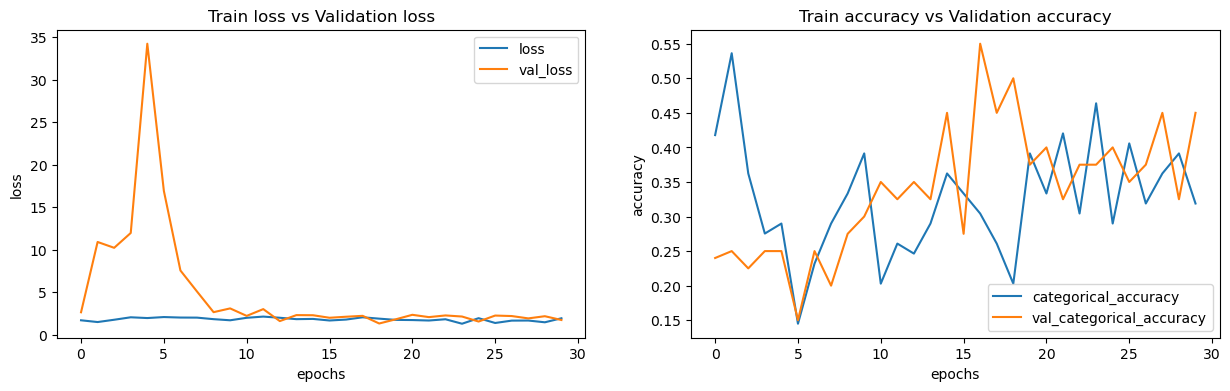

Max. Training Accuracy 0.5362318754196167
Max. Validation Accuracy 0.550000011920929


In [23]:
# print the history
plotModelHistory(history_base)

1/1 [==============================] - 1s 608ms/step

Confusion Matrix:::
[[3 7 0 0 0]
 [3 6 1 0 0]
 [2 2 2 0 2]
 [1 1 2 2 1]
 [1 0 1 2 1]]


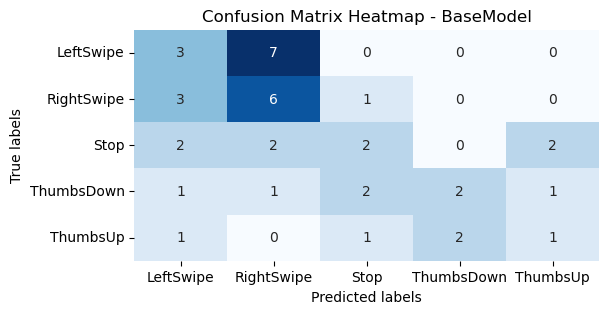

              precision    recall  f1-score   support

   LeftSwipe       0.30      0.30      0.30        10
  RightSwipe       0.38      0.60      0.46        10
        Stop       0.33      0.25      0.29         8
  ThumbsDown       0.50      0.29      0.36         7
    ThumbsUp       0.25      0.20      0.22         5

    accuracy                           0.35        40
   macro avg       0.35      0.33      0.33        40
weighted avg       0.35      0.35      0.34        40



In [24]:
# validation data check
actual_labels, predicted_labels = validate_data(model)
# show the classification report and confusion matrix
conf_matrix, class_report = showReport(actual_labels, predicted_labels, 'BaseModel')

In [25]:
# get the accuracy and loss of training
loss_train, acc_train, loss_val, acc_val = get_acc_loss(history_base)


The accuracy of the training ::: 0.319
The loss of the training ::: 1.941


The accuracy of the validation ::: 0.450
The loss of the validation ::: 1.738


In [26]:
# get the F1 score
f1_val = metrics.f1_score(actual_labels, predicted_labels, average='weighted')
f1_val

0.33894161394161393

In [27]:
# get the precision and recall
avg_recal_val = metrics.recall_score(actual_labels, predicted_labels, average='weighted')
avg_preci_val = metrics.precision_score(actual_labels, predicted_labels, average='weighted')

In [28]:
# add data to dataframe
results_multiclass.loc[len(results_multiclass)] = ['BaseModel', num_epochs, batch_size, n_frames, 
                                                   loss_train, acc_train, loss_val, acc_val,
                                                   f1_val, avg_recal_val, avg_preci_val]

In [29]:
results_multiclass.T

,0
model,BaseModel
epochs,30
batch_size,30
n_frames,30
training_loss,1.941267
training_accuracy,0.318841
validation_loss,1.738447
validation_accuracy,0.45
validation_f1,0.338942
validation_recall,0.35


### Model 2

**CONV2D + LSTM (Long short Term Memory)**

In [30]:
# initialize parameters
n_frames = 20
num_epochs = 30
batch_size = 30

In [31]:
# get the image tensor and initialize the new train generator and val_generator
img_tensor = getImgTensor(n_frames, 128)
train_generator = generator(train_path, train_doc, batch_size, img_tensor, True)
val_generator = generator(val_path, val_doc, batch_size, img_tensor, False)

In [32]:
# compute the steps for training and validation
steps_per_epoch, validation_steps = computeSteps(num_train_sequences, num_val_sequences, batch_size)

In [33]:
# initialize the callback
callback_list = callbacks('Conv2D_LSTM')

In [34]:
def defineModel(img_tensor):
    '''
    Function for the CONV2D and LSTM model with Timedistributed
    We use BatchNormalization and Maxpooling2D(2,2) and Dropout(0.2)
    Activation is relu in all layer with softmax in output
    '''
    
    inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

    model = Sequential([
        TimeDistributed(Conv2D(16, make2dFilter(3), padding='same', activation='relu'), input_shape=inputShape),
        TimeDistributed(BatchNormalization()),
        TimeDistributed(MaxPooling2D(make2dFilter(2))),

        TimeDistributed(Conv2D(32, make2dFilter(3), padding='same', activation='relu')),
        TimeDistributed(BatchNormalization()),
        TimeDistributed(MaxPooling2D(make2dFilter(2))),

        TimeDistributed(Conv2D(64, make2dFilter(3), padding='same', activation='relu')),
        TimeDistributed(BatchNormalization()),
        TimeDistributed(MaxPooling2D(make2dFilter(2))),

        TimeDistributed(Conv2D(128, make2dFilter(3), padding='same', activation='relu')),
        TimeDistributed(BatchNormalization()),
        TimeDistributed(MaxPooling2D(make2dFilter(2))),

        TimeDistributed(Conv2D(256, make2dFilter(3), padding='same', activation='relu')),
        TimeDistributed(BatchNormalization()),
        TimeDistributed(MaxPooling2D(make2dFilter(2))),

        TimeDistributed(Flatten()),
        LSTM(256),
        Dropout(0.2),
        Dense(256, activation='relu'),
        Dropout(0.2),

        Dense(5, activation='softmax')
    ], name="conv_2d_lstm")
    
    model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

model = defineModel(img_tensor)
model.summary()

2024-06-01 16:26:19.763796: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-01 16:26:19.764331: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-01 16:26:19.764667: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "conv_2d_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 128, 128, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 128, 128, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 64, 64, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 64, 64, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 64, 64, 32)  

In [35]:
# Initialize the generators
# we are augmenting data for the training but not for the validation
train_generator = generator(train_path, train_doc, batch_size, img_tensor, True)
val_generator = generator(val_path, val_doc, batch_size, img_tensor, False)

In [36]:
# compute the steps for training and validation
steps_per_epoch, validation_steps = computeSteps(num_train_sequences, num_val_sequences, batch_size)

In [37]:
# initialize the callback
callback_list = callbacks('Conv2D_LSTM')

In [38]:
# Train the model
history_C2D_LSTM= model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                        callbacks=callback_list, validation_data=val_generator, 
                        validation_steps=validation_steps)

Source path =  input/train ; batch size = 30
Epoch 1/30


2024-06-01 16:26:21.462586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-06-01 16:26:21.613847: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-01 16:26:21.614243: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra

23/23 [==============================] - ETA: 0s - loss: 1.4442 - categorical_accuracy: 0.3793Source path =  input/val ; batch size = 30


2024-06-01 16:28:15.212133: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-06-01 16:28:15.458259: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-01 16:28:15.458936: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra


Epoch 1: val_loss improved from inf to 2.09059, saving model to Conv2D_LSTM_2024-06-0116_10_00.592795/model-keras.keras
23/23 [==============================] - 117s 5s/step - loss: 1.4442 - categorical_accuracy: 0.3793 - val_loss: 2.0906 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 1.5180 - categorical_accuracy: 0.3623
Epoch 2: val_loss improved from 2.09059 to 2.01974, saving model to Conv2D_LSTM_2024-06-0116_10_00.592795/model-keras.keras
23/23 [==============================] - 14s 625ms/step - loss: 1.5180 - categorical_accuracy: 0.3623 - val_loss: 2.0197 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 1.5334 - categorical_accuracy: 0.3623
Epoch 3: val_loss improved from 2.01974 to 1.70933, saving model to Conv2D_LSTM_2024-06-0116_10_00.592795/model-keras.keras
23/23 [==============================] - 14s 593ms/step - loss: 1.5334 - categorica

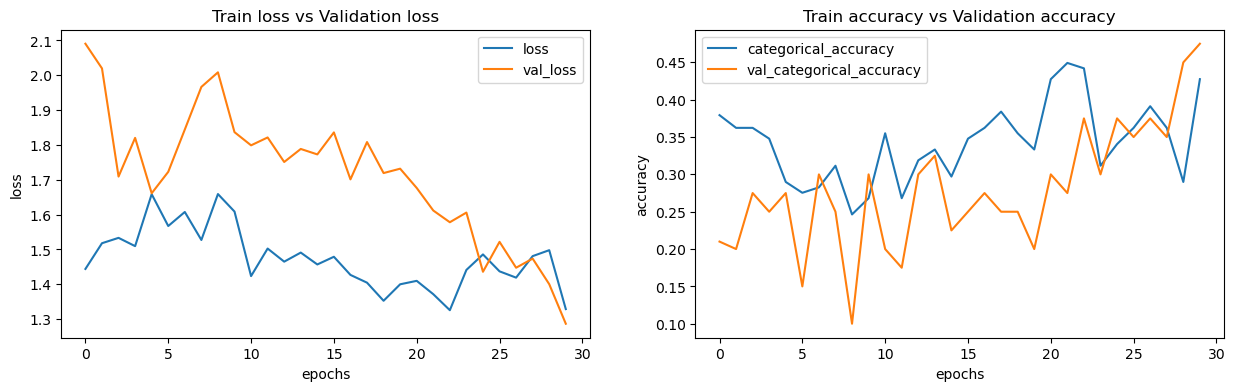

Max. Training Accuracy 0.4492753744125366
Max. Validation Accuracy 0.4749999940395355


In [39]:
# print the history
plotModelHistory(history_C2D_LSTM)

2024-06-01 16:34:57.296481: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-01 16:34:57.296890: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-01 16:34:57.297433: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 217ms/step

Confusion Matrix:::
[[1 0 1 0 5]
 [0 5 2 0 0]
 [0 2 1 3 4]
 [0 0 0 4 5]
 [0 0 0 2 5]]


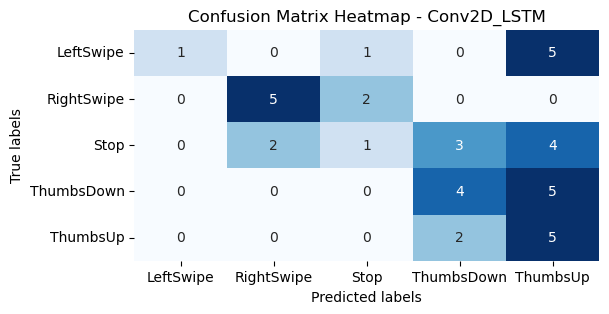

              precision    recall  f1-score   support

   LeftSwipe       1.00      0.14      0.25         7
  RightSwipe       0.71      0.71      0.71         7
        Stop       0.25      0.10      0.14        10
  ThumbsDown       0.44      0.44      0.44         9
    ThumbsUp       0.26      0.71      0.38         7

    accuracy                           0.40        40
   macro avg       0.53      0.42      0.39        40
weighted avg       0.51      0.40      0.37        40



In [40]:
# validation data check
actual_labels, predicted_labels = validate_data(model)
# show the classification report and confusion matrix
conf_matrix, class_report = showReport(actual_labels, predicted_labels, 'Conv2D_LSTM')

In [41]:
# get the accuracy and loss of training
loss_train, acc_train, loss_val, acc_val = get_acc_loss(history_C2D_LSTM)


The accuracy of the training ::: 0.428
The loss of the training ::: 1.329


The accuracy of the validation ::: 0.475
The loss of the validation ::: 1.287


In [42]:
f1_val = metrics.f1_score(actual_labels, predicted_labels, average='weighted')
f1_val

0.37177197802197803

In [43]:
# get the precision and recall
avg_recal_val = metrics.recall_score(actual_labels, predicted_labels, average='weighted')
avg_preci_val = metrics.precision_score(actual_labels, predicted_labels, average='weighted')

In [44]:
# add data to dataframe
results_multiclass.loc[len(results_multiclass)] = ['Conv2D_LSTM', num_epochs, batch_size, n_frames, loss_train, acc_train, loss_val, acc_val,
                                                   f1_val, avg_recal_val, avg_preci_val]

In [45]:
results_multiclass.T

,0,1
model,BaseModel,Conv2D_LSTM
epochs,30,30
batch_size,30,30
n_frames,30,20
training_loss,1.941267,1.328973
training_accuracy,0.318841,0.427536
validation_loss,1.738447,1.286937
validation_accuracy,0.45,0.475
validation_f1,0.338942,0.371772
validation_recall,0.35,0.4


### Model 3

**CONV2D with LSTM having 16 frames for 20 epochs**

In [46]:
# initialize parameters
n_frames = 16
num_epochs = 20
batch_size = 32

In [47]:
# get the image tensor and initialize the new train generator and val_generator
img_tensor = getImgTensor(n_frames, 100)
train_generator = generator(train_path, train_doc, batch_size, img_tensor, True)
val_generator = generator(val_path, val_doc, batch_size, img_tensor, False)

In [48]:
# compute the steps for training and validation
steps_per_epoch, validation_steps = computeSteps(num_train_sequences, num_val_sequences, batch_size)

In [49]:
# initialize the callback
callback_list = callbacks('Conv2D_LSTM_16F')

In [50]:
def defineModel(img_tensor):
    '''
    Function for the CONV2D and LSTM model with Time distributed
    We use BatchNormalization and Maxpooling2D(2,2) and Dropout(0.2)
    Activation is relu in all layer with softmax in output
    '''
    
    inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

    model = Sequential([
        TimeDistributed(Conv2D(16, make2dFilter(3), padding='same', activation='relu'), input_shape=inputShape),
        TimeDistributed(BatchNormalization()),
        TimeDistributed(MaxPooling2D(make2dFilter(2))),
        TimeDistributed(Dropout(0.2)),

        TimeDistributed(Conv2D(32, make2dFilter(3), padding='same', activation='relu')),
        TimeDistributed(BatchNormalization()),
        TimeDistributed(MaxPooling2D(make2dFilter(2))),
        TimeDistributed(Dropout(0.2)),

        TimeDistributed(Conv2D(64, make2dFilter(3), padding='same', activation='relu')),
        TimeDistributed(BatchNormalization()),
        TimeDistributed(MaxPooling2D(make2dFilter(2))),
        TimeDistributed(Dropout(0.2), name='Dropout'),

        TimeDistributed(Conv2D(128, make2dFilter(3), padding='same', activation='relu')),
        TimeDistributed(BatchNormalization()),
        TimeDistributed(MaxPooling2D(make2dFilter(2))),
        TimeDistributed(Dropout(0.2)),

        TimeDistributed(Conv2D(256, make2dFilter(3), padding='same', activation='relu')),
        TimeDistributed(BatchNormalization()),
        TimeDistributed(MaxPooling2D(make2dFilter(2))),
        TimeDistributed(Dropout(0.2)),

        TimeDistributed(Flatten()),
        LSTM(256),
        Dropout(0.2),
        Dense(256, activation='relu'),
        Dropout(0.2),

        Dense(5, activation='softmax')
    ], name="conv_2d_lstm")
    
    model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

In [51]:
# define the same model with different tensor shape
model = defineModel(img_tensor)
model.summary()

2024-06-01 16:34:59.601081: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-01 16:34:59.601603: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-01 16:34:59.601953: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "conv_2d_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 16, 100, 100, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 16, 100, 100, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 16, 50, 50, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 16, 50, 50, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 16, 50, 50, 32)  

In [52]:
# Train the model
history_C2D_LSTM_16F= model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                        callbacks=callback_list, validation_data=val_generator, 
                        validation_steps=validation_steps)

Source path =  input/train ; batch size = 32
Epoch 1/20


2024-06-01 16:35:00.973905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-06-01 16:35:01.165159: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-01 16:35:01.165578: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra

21/21 [==============================] - ETA: 0s - loss: 1.4587 - categorical_accuracy: 0.3567Source path =  input/val ; batch size = 32


2024-06-01 16:36:00.612751: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-06-01 16:36:00.789606: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-01 16:36:00.789991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra


Epoch 1: val_loss improved from inf to 1.93844, saving model to Conv2D_LSTM_16F_2024-06-0116_10_00.592795/model-keras.keras
21/21 [==============================] - 62s 3s/step - loss: 1.4587 - categorical_accuracy: 0.3567 - val_loss: 1.9384 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.2905 - categorical_accuracy: 0.4513
Epoch 2: val_loss did not improve from 1.93844
21/21 [==============================] - 44s 2s/step - loss: 1.2905 - categorical_accuracy: 0.4513 - val_loss: 2.9461 - val_categorical_accuracy: 0.1875 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 1.2805 - categorical_accuracy: 0.4496
Epoch 3: val_loss did not improve from 1.93844
21/21 [==============================] - 43s 2s/step - loss: 1.2805 - categorical_accuracy: 0.4496 - val_loss: 2.6386 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 4/20
21/21 [==============================] - ETA: 0s - loss: 1.2

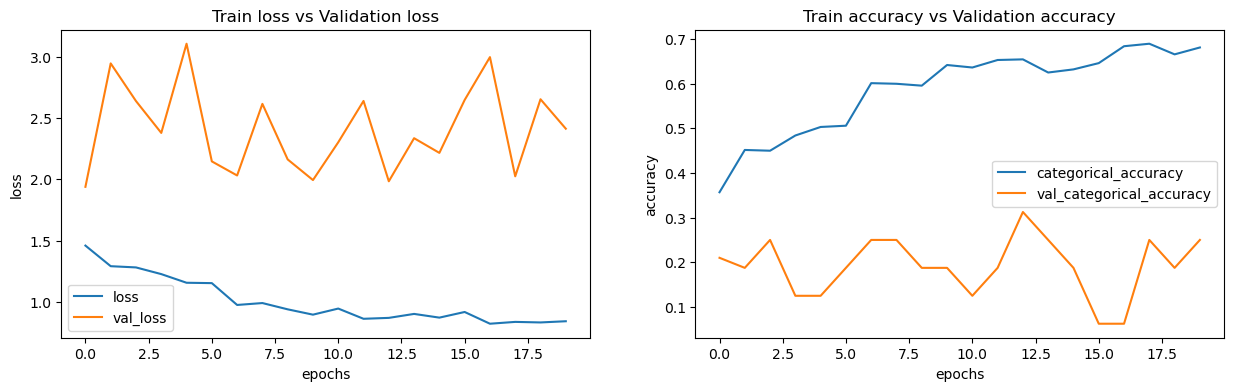

Max. Training Accuracy 0.6890756487846375
Max. Validation Accuracy 0.3125


In [53]:
# print the history
plotModelHistory(history_C2D_LSTM_16F)

2024-06-01 16:47:18.091449: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-01 16:47:18.092763: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-01 16:47:18.093653: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 67ms/step

Confusion Matrix:::
[[0 0 0 2 0]
 [0 0 0 2 0]
 [0 0 0 1 2]
 [0 0 0 6 0]
 [0 0 0 3 0]]


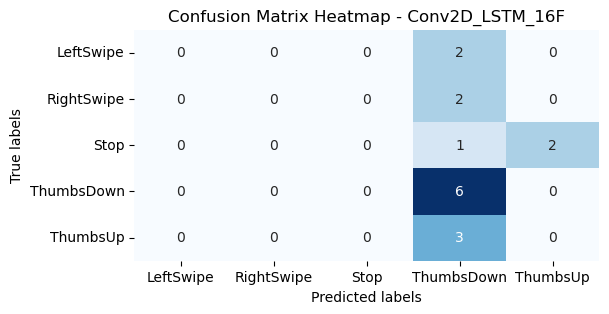

              precision    recall  f1-score   support

   LeftSwipe       0.00      0.00      0.00         2
  RightSwipe       0.00      0.00      0.00         2
        Stop       0.00      0.00      0.00         3
  ThumbsDown       0.43      1.00      0.60         6
    ThumbsUp       0.00      0.00      0.00         3

    accuracy                           0.38        16
   macro avg       0.09      0.20      0.12        16
weighted avg       0.16      0.38      0.22        16



In [54]:
# validation data check
actual_labels, predicted_labels = validate_data(model)
# show the classification report and confusion matrix
conf_matrix, class_report = showReport(actual_labels, predicted_labels, 'Conv2D_LSTM_16F')

In [55]:
# get the accuracy and loss of training
loss_train, acc_train, loss_val, acc_val = get_acc_loss(history_C2D_LSTM_16F)


The accuracy of the training ::: 0.681
The loss of the training ::: 0.841


The accuracy of the validation ::: 0.250
The loss of the validation ::: 2.413


In [56]:
# get the F1 score of validation
f1_val = metrics.f1_score(actual_labels, predicted_labels, average='weighted')
f1_val

0.22499999999999998

In [57]:
# get the precision and recall
avg_recal_val = metrics.recall_score(actual_labels, predicted_labels, average='weighted')
avg_preci_val = metrics.precision_score(actual_labels, predicted_labels, average='weighted')

In [59]:
# add data to dataframe
results_multiclass.loc[len(results_multiclass)] = ['Conv2D_LSTM_16F', num_epochs, batch_size, n_frames, 
                                                   loss_train, acc_train, loss_val, acc_val,
                                                   f1_val, avg_recal_val, avg_preci_val]

In [166]:
results_multiclass.T

,0,1,2
model,BaseModel,Conv2D_LSTM,Conv2D_LSTM_16F
epochs,30,30,20
batch_size,30,30,32
n_frames,30,20,16
training_loss,1.941267,1.328973,0.841119
training_accuracy,0.318841,0.427536,0.680672
validation_loss,1.738447,1.286937,2.413066
validation_accuracy,0.45,0.475,0.25
validation_f1,0.338942,0.371772,0.225
validation_recall,0.35,0.4,0.375


### Model 4

**Here We are trying to use a Hybrid model with Conv3D with custom HybridPool3D where we perform globalAveragepool and globalMaxPool 3D and we take the sum of the hybrid pool to see if the model performs better**

In [61]:
# initialize the parameters
n_frames = 30
num_epochs = 20
batch_size = 10

In [62]:
# get the image tensor and initialize the new train generator and val_generator
img_tensor = getImgTensor(n_frames, 128)
train_generator = generator(train_path, train_doc, batch_size, img_tensor, True) # augmentation is False
val_generator = generator(val_path, val_doc, batch_size, img_tensor, False)

In [63]:
# compute the steps for training and validation
steps_per_epoch, validation_steps = computeSteps(num_train_sequences, num_val_sequences, batch_size)

In [64]:
# initialize the callback
callback_list = callbacks('CONV3D_hybrid')

In [65]:
@keras.saving.register_keras_serializable(package='Custom', name='HybridPool3D')
class HybridPool3D(Layer):
    '''The resulting tensor contains a combination of the average values and 
    the maximum values from different regions of the input tensor.'''
    
    def __init__(self):
        super(HybridPool3D, self).__init__()
        self.avg_pool = tf.keras.layers.GlobalAveragePooling3D()
        self.max_pool = tf.keras.layers.GlobalMaxPooling3D()

    def call(self, inputs):
        avg_pooled = self.avg_pool(inputs)
        max_pooled = self.max_pool(inputs)
        return avg_pooled + max_pooled
    
def defineModel(img_tensor):
    '''
    Function to define the base model
    We use Conv3D with different filters
    We use GloabalAvgPool3D with BathNormalization
    Here we are using linear activation 
    After the CNN there are 3 Dense layers 
    We also use Dropout(0.2)
    '''
    inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

    model = Sequential()
    
    model.add(Conv3D(64, kernel_size=(3, 3, 3), strides=(3, 3, 3), padding='same', activation='relu', 
                     input_shape=inputShape))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Conv3D(32, kernel_size=(3, 3, 3), strides=(3, 3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Conv3D(16, kernel_size=(3, 3, 3), strides=(3, 3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Conv3D(8, kernel_size=(3, 3, 3), strides=(3, 3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(HybridPool3D())
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(5, activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

model = defineModel(img_tensor)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 10, 43, 43, 64)    5248      
                                                                 
 batch_normalization_15 (Bat  (None, 10, 43, 43, 64)   256       
 chNormalization)                                                
                                                                 
 dropout_11 (Dropout)        (None, 10, 43, 43, 64)    0         
                                                                 
 conv3d_4 (Conv3D)           (None, 4, 15, 15, 32)     55328     
                                                                 
 batch_normalization_16 (Bat  (None, 4, 15, 15, 32)    128       
 chNormalization)                                                
                                                                 
 dropout_12 (Dropout)        (None, 4, 15, 15, 32)    

In [66]:
# Train the model
history_C3D_Hyd= model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                        callbacks=callback_list, validation_data=val_generator, 
                        validation_steps=validation_steps)

Source path =  input/train ; batch size = 10
Epoch 1/20


2024-06-01 16:47:20.769080: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


67/67 [==============================] - ETA: 0s - loss: 1.6812 - categorical_accuracy: 0.2142Source path =  input/val ; batch size = 10


2024-06-01 16:48:45.375650: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 1.60854, saving model to CONV3D_hybrid_2024-06-0116_10_00.592795/model-keras.keras
67/67 [==============================] - 89s 1s/step - loss: 1.6812 - categorical_accuracy: 0.2142 - val_loss: 1.6085 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.5881 - categorical_accuracy: 0.2587
Epoch 2: val_loss improved from 1.60854 to 1.57494, saving model to CONV3D_hybrid_2024-06-0116_10_00.592795/model-keras.keras
67/67 [==============================] - 22s 337ms/step - loss: 1.5881 - categorical_accuracy: 0.2587 - val_loss: 1.5749 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 1.5831 - categorical_accuracy: 0.2736
Epoch 3: val_loss improved from 1.57494 to 1.56497, saving model to CONV3D_hybrid_2024-06-0116_10_00.592795/model-keras.keras
67/67 [==============================] - 23s 352ms/step - loss: 1.5831 - categ

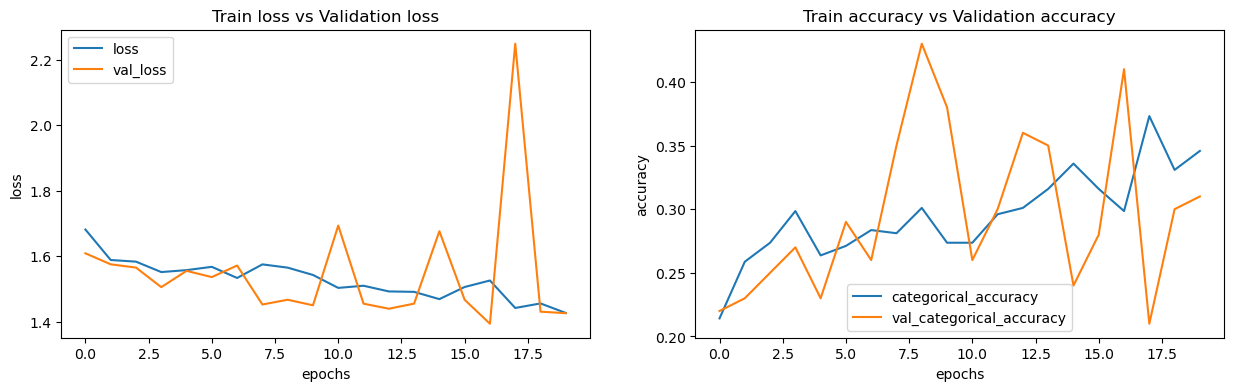

Max. Training Accuracy 0.3731343150138855
Max. Validation Accuracy 0.4300000071525574


In [67]:
# print the history
plotModelHistory(history_C3D_Hyd)

1/1 [==============================] - 0s 39ms/step

Confusion Matrix:::
[[ 6  7  1  2  2]
 [ 7 11  0  2  3]
 [ 7  4  0  4  7]
 [ 5  0  2  6  8]
 [ 4  1  0  1 10]]


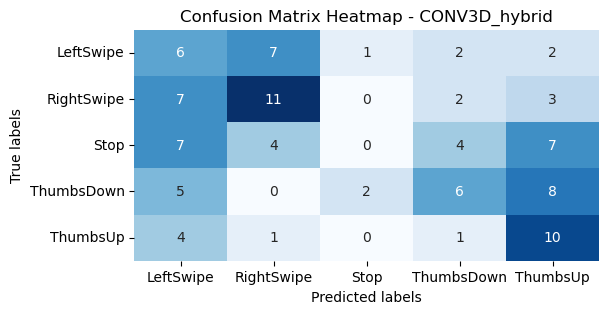

              precision    recall  f1-score   support

   LeftSwipe       0.21      0.33      0.26        18
  RightSwipe       0.48      0.48      0.48        23
        Stop       0.00      0.00      0.00        22
  ThumbsDown       0.40      0.29      0.33        21
    ThumbsUp       0.33      0.62      0.43        16

    accuracy                           0.33       100
   macro avg       0.28      0.34      0.30       100
weighted avg       0.28      0.33      0.30       100



In [68]:
# validation data check
actual_labels, predicted_labels = validate_data(model)
# show the classification report and confusion matrix
conf_matrix, class_report = showReport(actual_labels, predicted_labels, 'CONV3D_hybrid')

In [69]:
# get the accuracy and loss of training
loss_train, acc_train, loss_val, acc_val = get_acc_loss(history_C3D_Hyd)


The accuracy of the training ::: 0.346
The loss of the training ::: 1.426


The accuracy of the validation ::: 0.310
The loss of the validation ::: 1.426


In [70]:
f1_val = metrics.f1_score(actual_labels, predicted_labels, average='weighted')
f1_val

0.295522664199815

In [71]:
# get the precision and recall
avg_recal_val = metrics.recall_score(actual_labels, predicted_labels, average='weighted')
avg_preci_val = metrics.precision_score(actual_labels, predicted_labels, average='weighted')

In [72]:
# add data to dataframe
results_multiclass.loc[len(results_multiclass)] = ['CONV3D_hybrid', num_epochs, batch_size, n_frames, 
                                                   loss_train, acc_train, loss_val, acc_val,
                                                   f1_val, avg_recal_val, avg_preci_val]

In [174]:
results_multiclass.T

,0,1,2,3
model,BaseModel,Conv2D_LSTM,Conv2D_LSTM_16F,CONV3D_hybrid
epochs,30,30,20,20
batch_size,30,30,32,10
n_frames,30,20,16,30
training_loss,1.941267,1.328973,0.841119,1.426372
training_accuracy,0.318841,0.427536,0.680672,0.345771
validation_loss,1.738447,1.286937,2.413066,1.425692
validation_accuracy,0.45,0.475,0.25,0.31
validation_f1,0.338942,0.371772,0.225,0.295523
validation_recall,0.35,0.4,0.375,0.33


### Model 5

**Transfer learning Mobilenet with LSTM**

**Here we are using a pretrained model mobilenet and using LSTM to see if the model performs good**

**TimeDistributed learns along the time frame of a video sequence and tries to learn the behaviour**

**We are not setting the trainable = False and we are traning the model again with our data with some modification of batchnormalization, pooling and flatening with LSTM of 256 filters , dropout**

In [135]:
# initialize the parameters
n_frames = 30
num_epochs = 27
batch_size = 30

In [136]:
# get the image tensor and initialize the new train generator and val_generator
img_tensor = getImgTensor(n_frames, 128)
train_generator = generator(train_path, train_doc, batch_size, img_tensor, False) # augmentation is False
val_generator = generator(val_path, val_doc, batch_size, img_tensor, False)

In [137]:
# compute the steps for training and validation
steps_per_epoch, validation_steps = computeSteps(num_train_sequences, num_val_sequences, batch_size)

In [138]:
# initialize the callback
callback_list = callbacks('mobilenet_lstm')

In [139]:
def defineModel(inputShape,mobilenet):
    '''
    Function for the CONV2D and LSTM model on pretrained mobilenet model
    We use BatchNormalization and Maxpooling2D(2,2) and Dropout(0.2)
    Activation is relu in all layer with softmax in output
    '''

    model = Sequential([TimeDistributed(mobilenet, input_shape=inputShape)], name="mobilenet_lstm")

    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D(make2dFilter(2))))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(256))
    model.add(Dropout(0.2))
    model.add(Dense(5, activation='softmax'))
    
    model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])
mobilenet = MobileNet(weights='imagenet', include_top=False, input_shape=inputShape[1:])
model = defineModel(inputShape, mobilenet)
model.summary()

2024-06-01 17:48:15.963521: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-01 17:48:15.964000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-01 17:48:15.964409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "mobilenet_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_44 (TimeDi  (None, 30, 4, 4, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_45 (TimeDi  (None, 30, 4, 4, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_46 (TimeDi  (None, 30, 2, 2, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_47 (TimeDi  (None, 30, 4096)         0         
 stributed)                                                      
                                                                 
 lstm_4 (LSTM)               (None, 256)            

In [140]:
# Train the model
history_mobilenet= model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                        callbacks=callback_list, validation_data=val_generator, 
                        validation_steps=validation_steps)

Source path =  input/train ; batch size = 30
Epoch 1/27


2024-06-01 17:48:21.853531: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-06-01 17:48:22.080269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-01 17:48:22.080844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra

23/23 [==============================] - ETA: 0s - loss: 0.8691 - categorical_accuracy: 0.6772 Source path =  input/val ; batch size = 30


2024-06-01 17:52:51.008607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-06-01 17:52:51.195803: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-01 17:52:51.196212: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra


Epoch 1: val_loss improved from inf to 1.02790, saving model to mobilenet_lstm_2024-06-0116_10_00.592795/model-keras.keras
23/23 [==============================] - 276s 12s/step - loss: 0.8691 - categorical_accuracy: 0.6772 - val_loss: 1.0279 - val_categorical_accuracy: 0.6100 - lr: 0.0010
Epoch 2/27
23/23 [==============================] - ETA: 0s - loss: 0.9523 - categorical_accuracy: 0.6232
Epoch 2: val_loss did not improve from 1.02790
23/23 [==============================] - 30s 1s/step - loss: 0.9523 - categorical_accuracy: 0.6232 - val_loss: 1.3921 - val_categorical_accuracy: 0.2750 - lr: 0.0010
Epoch 3/27
23/23 [==============================] - ETA: 0s - loss: 1.2311 - categorical_accuracy: 0.4783
Epoch 3: val_loss did not improve from 1.02790
23/23 [==============================] - 30s 1s/step - loss: 1.2311 - categorical_accuracy: 0.4783 - val_loss: 1.6207 - val_categorical_accuracy: 0.2250 - lr: 0.0010
Epoch 4/27
23/23 [==============================] - ETA: 0s - loss: 1.

Epoch 25/27
23/23 [==============================] - ETA: 0s - loss: 0.6235 - categorical_accuracy: 0.8116
Epoch 25: val_loss did not improve from 0.38627
23/23 [==============================] - 33s 1s/step - loss: 0.6235 - categorical_accuracy: 0.8116 - val_loss: 0.3982 - val_categorical_accuracy: 0.8250 - lr: 2.0000e-04
Epoch 26/27
23/23 [==============================] - ETA: 0s - loss: 0.5185 - categorical_accuracy: 0.8551
Epoch 26: val_loss did not improve from 0.38627
23/23 [==============================] - 32s 1s/step - loss: 0.5185 - categorical_accuracy: 0.8551 - val_loss: 0.4421 - val_categorical_accuracy: 0.8250 - lr: 2.0000e-04
Epoch 27/27
23/23 [==============================] - ETA: 0s - loss: 0.4342 - categorical_accuracy: 0.8986
Epoch 27: val_loss improved from 0.38627 to 0.27521, saving model to mobilenet_lstm_2024-06-0116_10_00.592795/model-keras.keras
23/23 [==============================] - 32s 1s/step - loss: 0.4342 - categorical_accuracy: 0.8986 - val_loss: 0.27

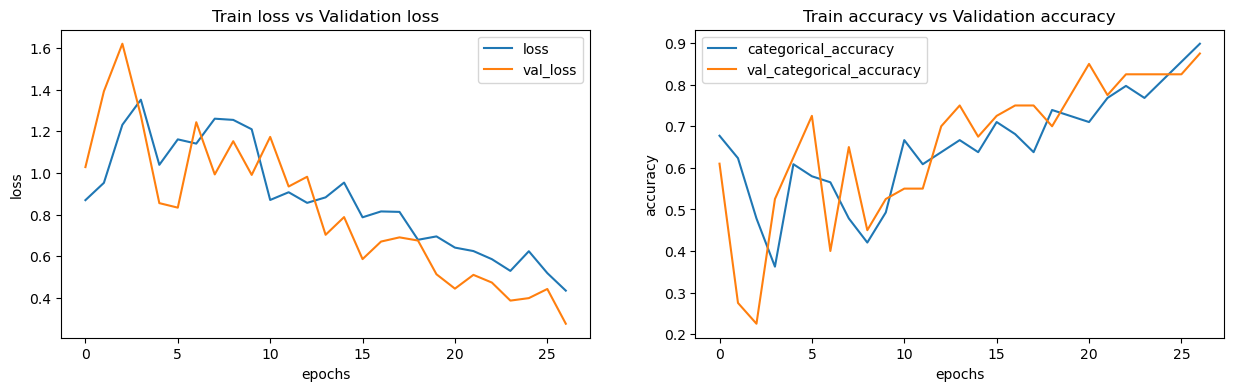

Max. Training Accuracy 0.8985507488250732
Max. Validation Accuracy 0.875


In [141]:
# print the history
plotModelHistory(history_mobilenet)

2024-06-01 18:26:14.706205: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-01 18:26:14.706638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-01 18:26:14.707113: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 486ms/step

Confusion Matrix:::
[[ 3  4  0  2  0]
 [ 1  5  0  0  0]
 [ 0  0  8  0  0]
 [ 0  0  0 10  0]
 [ 0  0  1  0  6]]


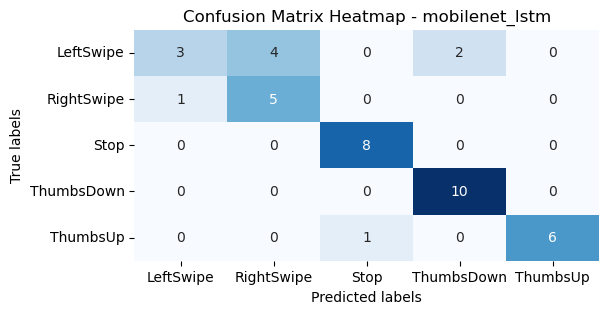

              precision    recall  f1-score   support

   LeftSwipe       0.75      0.33      0.46         9
  RightSwipe       0.56      0.83      0.67         6
        Stop       0.89      1.00      0.94         8
  ThumbsDown       0.83      1.00      0.91        10
    ThumbsUp       1.00      0.86      0.92         7

    accuracy                           0.80        40
   macro avg       0.81      0.80      0.78        40
weighted avg       0.81      0.80      0.78        40



In [142]:
# validation data check
actual_labels, predicted_labels = validate_data(model)
# show the classification report and confusion matrix
conf_matrix, class_report = showReport(actual_labels, predicted_labels, 'mobilenet_lstm')

In [143]:
# get the accuracy and loss of training
loss_train, acc_train, loss_val, acc_val = get_acc_loss(history_mobilenet)


The accuracy of the training ::: 0.899
The loss of the training ::: 0.434


The accuracy of the validation ::: 0.875
The loss of the validation ::: 0.275


In [144]:
f1_val = metrics.f1_score(actual_labels, predicted_labels, average='weighted')
f1_val

0.7808926367749895

In [145]:
# get the precision and recall
avg_recal_val = metrics.recall_score(actual_labels, predicted_labels, average='weighted')
avg_preci_val = metrics.precision_score(actual_labels, predicted_labels, average='weighted')

In [85]:
# add data to dataframe
results_multiclass.loc[len(results_multiclass)] = ['mobilenet_lstm', num_epochs, batch_size, n_frames, 
                                                   loss_train, acc_train, loss_val, acc_val,
                                                   f1_val, avg_recal_val, avg_preci_val]

In [175]:
results_multiclass.T

,0,1,2,3,4
model,BaseModel,Conv2D_LSTM,Conv2D_LSTM_16F,CONV3D_hybrid,mobilenet_lstm
epochs,30,30,20,20,27
batch_size,30,30,32,10,30
n_frames,30,20,16,30,30
training_loss,1.941267,1.328973,0.841119,1.426372,0.434183
training_accuracy,0.318841,0.427536,0.680672,0.345771,0.898551
validation_loss,1.738447,1.286937,2.413066,1.425692,0.275206
validation_accuracy,0.45,0.475,0.25,0.31,0.875
validation_f1,0.338942,0.371772,0.225,0.295523,0.780893
validation_recall,0.35,0.4,0.375,0.33,0.8


**Model4 using time distributed with Time distributed mobilenet,LSTM  performs the best with image resolution 128*128 , we find a validation accuracy of 87% with less gap in the lossthan others**

## Testing with unseen data


**In order to test the model , since we did not have images , we took farmes of our team members doing the geustures to pass in to inference**

In [206]:
from tensorflow.keras.models import load_model

In [355]:
def test_data(model, test_generator, test_steps):
    '''Function to validate data'''
    # Create empty lists to store the actual and predicted labels for validaiton data 
    actual_labels = []
    predicted_labels = []

    # Iterate over the generator to obtain the actual labels
    for i in range(test_steps):
        # Get the next batch of images and labels from the generator
        batch_x, batch_y = next(test_generator)
        
        #print("actual",batch_y)

        # Convert one-hot encoded labels to class indices
        actual_labels.extend(np.argmax(batch_y, axis=1))

        # Make predictions for the batch
        predictions = model.predict(batch_x)
        
        #print("predicted",predictions)

        # Convert predicted probabilities to class indices
        predicted_labels.extend(np.argmax(predictions, axis=1))
        
    return actual_labels, predicted_labels


In [389]:
# read the train and the validation file and initialize the batch size
test_doc = np.random.permutation(open('input/test.csv').readlines())

In [390]:
# curr_dt_time = datetime.datetime.now()
test_path = 'input/test'

num_test_sequences = len(test_doc)
print('# test sequences =', num_test_sequences)

batch_size = 1
print ('# batchSize =', batch_size)

n_frames = 30
print('# no of frames =', n_frames)

# test sequences = 12
# batchSize = 1
# no of frames = 30


In [391]:
if (num_test_sequences%batch_size) == 0:
    test_steps = int(num_test_sequences/batch_size)
else:
    test_steps = (num_test_sequences//batch_size) + 1
    
test_steps

12

In [392]:
# get the image tensor and initialize the new train generator and val_generator
img_tensor = getImgTensor(n_frames, 128)
test_generator = generator(test_path, test_doc, batch_size, img_tensor, False)

In [423]:
sample_test_batch_data, sample_test_batch_labels = next(test_generator)
print(sample_test_batch_data.shape)

(1, 30, 128, 128, 3)


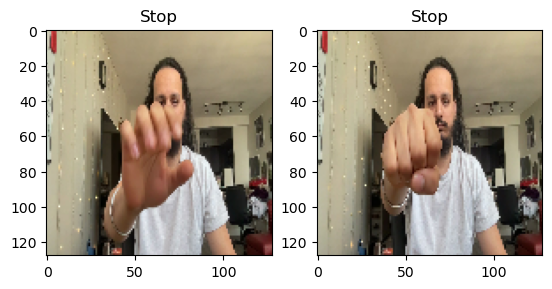

In [424]:
# lets plot some sample images
# plot generated sample images
fig, ax = plt.subplots(1,2)
ax[0].imshow(sample_test_batch_data[0,26,:,:,:]) 
ax[0].title.set_text(f"{y[np.argmax(sample_test_batch_labels[:10])]}")
ax[1].imshow(sample_test_batch_data[0,1,:,:,:])
ax[1].title.set_text(f"{y[np.argmax(sample_test_batch_labels[:1])]}")
plt.show()

In [362]:
# get the image tensor and initialize the new train generator and val_generator
img_tensor = getImgTensor(n_frames, 128)
test_generator = generator(test_path, test_doc, batch_size, img_tensor, False)

In [324]:
# load the best model
#modelToLoad = 'mobilenet_lstm_2024-06-0100_04_37.226216/model-keras.keras'

modelToLoad = 'mobilenet_lstm_2024-06-0116_10_00.592795/model-keras.keras'
#modelToLoad = 'model_init_2024-05-1522_45_47.146370/model-keras'
#modelToLoad = 'model-keras.keras'

In [325]:
model = load_model(modelToLoad)
#model = keras.layers.TFSMLayer('model_init_2024-05-1522_45_47.146370/model-keras', call_endpoint='serving_default')
model.summary()

Model: "mobilenet_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_44 (TimeDi  (None, 30, 4, 4, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_45 (TimeDi  (None, 30, 4, 4, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_46 (TimeDi  (None, 30, 2, 2, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_47 (TimeDi  (None, 30, 4096)         0         
 stributed)                                                      
                                                                 
 lstm_4 (LSTM)               (None, 256)            

2024-06-02 19:09:47.550066: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-02 19:09:47.550473: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-02 19:09:47.550943: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [353]:
# get the image tensor and initialize the new train generator and val_generator
# img_tensor = getImgTensor(n_frames, 128)
# test_generator = generator(test_path, test_doc, batch_size, img_tensor, False)
actual_labels, predicted_labels = test_data(model, test_generator, test_steps)

Source path =  input/test ; batch size = 1
1/1 [==============================] - 0s 52ms/step


In [158]:
len(actual_labels), len(predicted_labels)

(12, 12)

In [363]:
actual_labels , predicted_labels

([4, 1, 2, 2, 0, 3, 3, 1, 4, 4, 0, 2], [4, 1, 2, 2, 1, 2, 3, 1, 4, 4, 1, 2])


Confusion Matrix:::
[[0 2 0 0 0]
 [0 2 0 0 0]
 [0 0 3 0 0]
 [0 0 1 1 0]
 [0 0 0 0 3]]


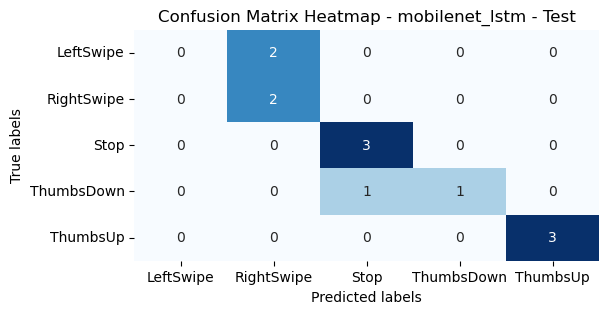

              precision    recall  f1-score   support

   LeftSwipe       0.00      0.00      0.00         2
  RightSwipe       0.50      1.00      0.67         2
        Stop       0.75      1.00      0.86         3
  ThumbsDown       1.00      0.50      0.67         2
    ThumbsUp       1.00      1.00      1.00         3

    accuracy                           0.75        12
   macro avg       0.65      0.70      0.64        12
weighted avg       0.69      0.75      0.69        12



In [354]:
# show the classification report and confusion matrix
conf_matrix, class_report = showReport(actual_labels, predicted_labels, 'mobilenet_lstm - Test')

**We see the model is performing good on the unseen data with an accuracy of 75%, However it is getting confused with the leftswipe and right swipe, may be we need some data preprocessing as lighting condition and background makes a difference, This would be something w.r.t future work**

**The model is a timedistributed LSTM mobilenet which reads frames accross a time frame and predicts a label for each 30 frames, so ploting some predicted images wont make much of sense, However we have also ran this model for a live stream of video where it performed good and fast, we have submitted that separately , please have a look.**